# Setup

In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 11.7 MB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 25.2 MB/s eta 0:00:01     |██████████████████████████████▌ | 10.7 MB 25.2 MB/s eta 0:00:01
     |████████████████████████████████| 31.2 MB 26.0 MB/s eta 0:00:01    |███████                         | 6.9 MB 15.2 MB/s eta 0:00:02
     |████████████████████████████████| 1.2 MB 59 kB/s eta 0:00:0101
     |████████████████████████████████| 944 kB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 34.1 MB/s eta 0:00:01
     |████████████████████████████████| 43.4 MB 23.2 MB/s eta 0:00:01    |███                             | 3.9 MB 28.6 MB/s eta 0:00:02     |███████████████████▌            | 26.4 MB 23.2 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dense, Activation, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

seed = 0

data = pd.read_csv('name_gender.csv')
print(f'Size of dataset: {len(data)}')

Size of dataset: 95025


In [3]:
data.describe()

,name,gender
count,95025,95025
unique,95025,2
top,Aaban&&,F
freq,1,60304


In [4]:
data.isnull().values.any() # No missing values

False

In [5]:
''.join(data['name'].values).isascii() # No accented characters

True

In [6]:
data['gender'].value_counts() # Class frequencies

F    60304
M    34721
Name: gender, dtype: int64

# Data cleaning and preparation

In [7]:
# List of non-alphabetic names
print(data[data['name'].str.contains('\W|\d|_')])

            name gender
0        Aaban&&      M
1         Aabha*      F
4          Aada_      F
10       Aadhav+      M
13      Aadhira4      F
...          ...    ...
94826   Zyair770      M
94874  Zyheir887      M
94915    Zykir24      M
94957  Zymirah11      F
94995     Zyri*&      F

[65 rows x 2 columns]


The following step removes non-alphabetic characters (numbers, symbols) from the names.

In [8]:
data['name'] = data['name'].str.replace('\W|\d|_','',regex=True)

In [9]:
# Split dataset stratified by gender before tokenizing to avoid leakage of test set info into training features
X_train, X_test, y_train, y_test = train_test_split(data['name'], data['gender'], test_size=0.1, \
                                                    random_state=seed, stratify=data['gender'])

# Modelling

Various models will be tried. 

Additionally, each model will be trained to 2 different sets of input features. First, a set of ngrams will be created from each name using sklearn's count vectorizer, essentially a bag of words approach before applying a machine learning model. The second method will further convert the count vectors into TF-IDF vectors.

Applying TF-IDF typically scales down the impact of tokens that are common in a corpus (hence less informative), although it is not clear that that might be the case for this problem. The higher the score, the more relevant that token is in that particular document.

In [10]:
ngram_upper = int(np.floor(np.mean(data['name'].apply(len))))
print(f'Average word length: {ngram_upper}')

Average word length: 6


A minimum of 2 characters and a maximum of 6 (mean word length) is used for constructing ngrams.

For hyerparameter tuning, stratified 5-fold CV will be used. However, tokenization will only be performed after splitting the dataset in order to prevent the validation set from having any info on the features of the other training folds. This procedure will be combined with gridsearchcv using a pipeline.

## Logistic regression

### BoW

In [15]:
# This tuning section was iteratively run to search for optimal hyperparameters without overfitting.
# I avoided single comprehensive searches as my computer was overheating and crashing. 
# The results printed here are my final results

# As GridsearchCV optimizes for the best validation score, it is likely to overfit since it ignores the training score 
# in its selection. The training scores are therefore printed and included in the manual selection of the best 
# hyperparameters to use

# Pipeline for tokenization and modelling
pipeline = make_pipeline(
        CountVectorizer(analyzer='char_wb', ngram_range=(2,ngram_upper)),
        LogisticRegression(max_iter=200)
        )

# Gridsearch with 5-fold CV
parameters = {'logisticregression__C':[0.005,0.006,0.007]}
lr_1 = GridSearchCV(pipeline, param_grid=parameters, cv=5, verbose=1, return_train_score=True) # Monitor for overfitting
lr_1.fit(X_train, y_train)

pd.DataFrame(lr_1.cv_results_)[['params','mean_test_score','rank_test_score','mean_train_score']]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,params,mean_test_score,rank_test_score,mean_train_score
0,{'logisticregression__C': 0.005},0.865953,3,0.872653
1,{'logisticregression__C': 0.006},0.868595,2,0.875827
2,{'logisticregression__C': 0.007},0.870758,1,0.878829


In [16]:
print(f'Scores for tuned LR model\nTrain: {round(lr_1.score(X_train, y_train),3)}\nTest: {round(lr_1.score(X_test, y_test),3)}')

Scores for tuned LR model
Train: 0.882
Test: 0.876


### tfidf

In [31]:
# Pipeline using TF-IDF vectorizer

pipeline = make_pipeline(
        TfidfVectorizer(analyzer='char_wb', ngram_range=(2,ngram_upper)),
        LogisticRegression(max_iter=200)
        )

parameters = {'logisticregression__C':[0.13,0.15,0.18]}
lr_2 = GridSearchCV(pipeline, param_grid=parameters, cv=5, verbose=2, return_train_score=True) # Monitor for overfitting
lr_2.fit(X_train, y_train)
pd.DataFrame(lr_2.cv_results_)[['params','mean_test_score','rank_test_score','mean_train_score']]

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .........................logisticregression__C=0.13; total time=  10.2s
[CV] END .........................logisticregression__C=0.13; total time=   9.2s
[CV] END .........................logisticregression__C=0.13; total time=   9.0s
[CV] END .........................logisticregression__C=0.13; total time=   9.6s
[CV] END .........................logisticregression__C=0.13; total time=  10.5s
[CV] END .........................logisticregression__C=0.15; total time=   8.4s
[CV] END .........................logisticregression__C=0.15; total time=   7.9s
[CV] END .........................logisticregression__C=0.15; total time=   9.3s
[CV] END .........................logisticregression__C=0.15; total time=   7.9s
[CV] END .........................logisticregression__C=0.15; total time=   9.7s
[CV] END .........................logisticregression__C=0.18; total time=   9.3s
[CV] END .........................logisticregress

,params,mean_test_score,rank_test_score,mean_train_score
0,{'logisticregression__C': 0.13},0.864245,3,0.876953
1,{'logisticregression__C': 0.15},0.867613,2,0.880966
2,{'logisticregression__C': 0.18},0.871191,1,0.885871


In [32]:
print(f'Scores for tuned LR model\nTrain: {round(lr_2.score(X_train, y_train),3)}\nTest: {round(lr_2.score(X_test, y_test),3)}')

Scores for tuned LR model
Train: 0.889
Test: 0.879


## Multinomial NB

The code is identical to the ones above except for the different model used.

### BoW

In [42]:
pipeline = make_pipeline(
        CountVectorizer(analyzer='char_wb', ngram_range=(2,ngram_upper)),
        MultinomialNB()
        )

parameters = {'multinomialnb__alpha':[4]}
nb_1 = GridSearchCV(pipeline, param_grid=parameters, cv=5, verbose=1, return_train_score=True) # Monitor for overfitting
nb_1.fit(X_train, y_train)

pd.DataFrame(nb_1.cv_results_)[['params','mean_test_score','rank_test_score','mean_train_score']]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,params,mean_test_score,rank_test_score,mean_train_score
0,{'multinomialnb__alpha': 4},0.861848,1,0.901291


In [43]:
print(f'Scores for tuned NB model\nTrain: {round(nb_1.score(X_train, y_train),3)}\nTest: {round(nb_1.score(X_test, y_test),3)}')

Scores for tuned NB model
Train: 0.902
Test: 0.87


### tdidf

In [44]:
pipeline = make_pipeline(
        TfidfVectorizer(analyzer='char_wb', ngram_range=(2,ngram_upper)),
        MultinomialNB()
        )

parameters = {'multinomialnb__alpha':[2,3,5]}
nb_2 = GridSearchCV(pipeline, param_grid=parameters, cv=5, verbose=1, return_train_score=True) # Monitor for overfitting
nb_2.fit(X_train, y_train)

pd.DataFrame(nb_2.cv_results_)[['params','mean_test_score','rank_test_score','mean_train_score']]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,params,mean_test_score,rank_test_score,mean_train_score
0,{'multinomialnb__alpha': 2},0.809371,1,0.856192
1,{'multinomialnb__alpha': 3},0.784091,2,0.819184
2,{'multinomialnb__alpha': 5},0.748556,3,0.770673


In [45]:
print(f'Scores for tuned NB model\nTrain: {round(nb_2.score(X_train, y_train),3)}\nTest: {round(nb_2.score(X_test, y_test),3)}')

Scores for tuned NB model
Train: 0.862
Test: 0.821


## SVC

### BOW

In [21]:
# Fail to converge, not scalable method

In [15]:
pipeline = make_pipeline(
        CountVectorizer(analyzer='char_wb', ngram_range=(2,ngram_upper)),
        StandardScaler(with_mean=False),
        LinearSVC(max_iter=5000)
        )

parameters = {'linearsvc__C':[5]}
svc_1 = GridSearchCV(pipeline, param_grid=parameters, cv=5, verbose=2, return_train_score=True) # Monitor for overfitting
svc_1.fit(X_train, y_train)

pd.DataFrame(svc_1.cv_results_)[['params','mean_test_score','rank_test_score','mean_train_score']]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .....................................linearsvc__C=5; total time= 1.4min


KeyboardInterrupt: 

## LSTM

A separate procedure for data preprocessing is used for training a LSTM.

In [11]:
data['name'] = data['name'].str.lower()

# Construct a vocabulary including 'END' token
vocab = set(''.join(data['name']))
vocab.add('END')

# Mapping characters to indices
char_index = dict((c, i) for i, c in enumerate(vocab))

In [12]:
# Tokenizing X and y datasets for use by LSTM

X = []
y = []
maxlen = 20

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    tmp = np.zeros(len(vocab));
    tmp[i] = 1
    return list(tmp)

# Truncate names and create the matrix
def prepare_X(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        new_list.append(tmp)

    return new_list


X = prepare_X(data['name'].values)

# Label Encoding of y
def prepare_y(y):
    new_list = []
    for i in y:
        if i == 'M':
            new_list.append([1,0])
        else:
            new_list.append([0,1])

    return new_list

y = prepare_y(data['gender'])

In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)

In [14]:
# Model definition
model = Sequential()
model.add(Bidirectional(LSTM(512, return_sequences=True), backward_layer=LSTM(512, return_sequences=True, go_backwards=True), input_shape=(maxlen,len(vocab))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(0.2))
model.add(Dense(2, activity_regularizer=l2(0.002)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20, 1024)         2211840   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 20, 1024)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1024)             6295552   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
 activation (Activation)     (None, 2)                 0

In [16]:
callback = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('lstm/model{epoch:08d}.h5', monitor='val_loss', mode='min', verbose=1)
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='max')

In [17]:
batch_size = 512
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=10, verbose=1, validation_data =(X_test, y_test), callbacks=[callback, mc, reduce_lr_acc])

Epoch 1/10
168/168 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.7731
Epoch 00001: saving model to lstm/model00000001.h5
168/168 [==============================] - 673s 4s/step - loss: 0.4805 - accuracy: 0.7731 - val_loss: 0.4145 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 2/10
168/168 [==============================] - ETA: 0s - loss: 0.3825 - accuracy: 0.8341
Epoch 00002: saving model to lstm/model00000002.h5
168/168 [==============================] - 673s 4s/step - loss: 0.3825 - accuracy: 0.8341 - val_loss: 0.3623 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 3/10
168/168 [==============================] - ETA: 0s - loss: 0.3541 - accuracy: 0.8486
Epoch 00003: saving model to lstm/model00000003.h5
168/168 [==============================] - 629s 4s/step - loss: 0.3541 - accuracy: 0.8486 - val_loss: 0.3562 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 4/10
168/168 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.8563
Epoch 00004: saving model to

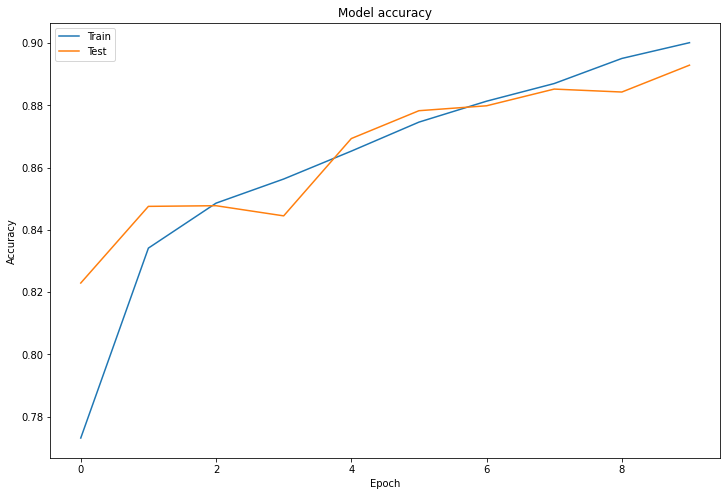

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [20]:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# App

In [22]:
model = tensorflow.keras.models.load_model('my_model')

In [29]:
model.predict(X)

array([[0.00608571, 0.9939143 ]], dtype=float32)

In [27]:
X = prepare_X(['aabriella'])

In [30]:
prepare_y(['F'])

[[0, 1]]

In [28]:
X

[[[0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0